## Extracción de la información

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import numpy as np
from typing import List, Tuple
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt
import folium
from folium import plugins
import time
from IPython.display import HTML, display
import json

### Web Scraping

Para extraer la información, se creó un bot que consulta ruta por ruta en la página **Mejores Rutas**. Utilizando expresiones regulares (regex) y técnicas de manipulación de cadenas, se extrae la información relevante y se organiza en tres diferentes **DataFrames**:

1. **Distancias:** Contiene la información relacionada con las distancias entre rutas.
2. **Tiempos:** Almacena los tiempos estimados de recorrido.
3. **Peajes:** Incluye los costos asociados a los peajes de las rutas.

Cada uno de estos **DataFrames** se guarda como un archivo CSV. Esto permite evitar la ejecución repetida del script, ya que el proceso de extracción es lento debido al alto número de peticiones HTTPS necesarias (alrededor de 1,000 solicitudes). Este proceso puede tardar aproximadamente **20 minutos** y recargar significativamente la página web.

**RECOMENDACIÓN:**  
Es preferible importar los archivos CSV con la información ya procesada en lugar de ejecutar nuevamente el script. De esta manera, se evita la sobrecarga del sitio web y se optimiza el tiempo.

**Página web de origen:** [MejoresRutas](https://mx.mejoresrutas.com/)

In [5]:
def get_city_matrices(capitales):
    # Convertir lista de capitales a array de NumPy
    capitales = np.array(capitales)
    n = len(capitales)

    # Inicializar matrices NumPy
    distancias = np.zeros((n, n))
    tiempos = np.zeros((n, n))
    peajes = np.zeros((n, n))

    # Patrones de regex
    patternDistancia = r"\d{1,3}(?:[\.,]\d{3})*(?:\.\d+)?"

    # Headers para la petición HTTP (importante para evitar bloqueos)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    for i in range(n):
        for j in range(n):
            if i != j:  # No procesar cuando origen = destino
                origen = capitales[i].replace(" ", "+")
                destino = capitales[j].replace(" ", "+")

                url = f"https://mx.mejoresrutas.com/distancias/?from={origen}&to={destino}"
                try:
                    response = requests.get(url, headers=headers)
                    soup = BeautifulSoup(response.text, "html.parser")

                    tds = soup.find(class_="l-summary-block").find_all("td")

                    # Extraer distancia
                    distancia = tds[3].text
                    match = re.search(patternDistancia, distancia)
                    if match:
                        distancias[i,j] = int(match.group().replace(".",""))

                    # Extraer tiempo
                    tiempo = tds[5].text.replace(" ","").replace("min","").replace("\n","").split("h")
                    if len(tiempo)==1:
                      horas = int(tiempo[0])/60
                      minutos = 0
                    else:
                      horas = int(tiempo[0])
                      minutos = float(tiempo[1])/60 if tiempo[1] != '' else 0
                    tiempos[i,j] = horas + minutos

                    # Extraer peaje
                    try:
                        peaje = tds[11].text
                        match = re.search(r"\d+(\.\d+|\d)", peaje)
                        if match:
                            peajes[i,j] = int(match.group().replace(".",""))
                    except:
                        peajes[i,j] = 0


                except Exception as e:
                    print(f"Error procesando {origen} a {destino}: {str(e)}")
                    continue

    return distancias, tiempos, peajes

def save_to_csv(capitales, distancias, tiempos, peajes):
    # Crear DataFrames para cada matriz
    df_distancias = pd.DataFrame(distancias, index=capitales, columns=capitales)
    df_tiempos = pd.DataFrame(tiempos, index=capitales, columns=capitales)
    df_peajes = pd.DataFrame(peajes, index=capitales, columns=capitales)

    # Guardar en CSV
    df_distancias.to_csv('distancias.csv')
    df_tiempos.to_csv('tiempos.csv')
    df_peajes.to_csv('peajes.csv')

    # También guardar un archivo único con toda la información
    combined_data = {
        'origen': [],
        'destino': [],
        'distancia_km': [],
        'tiempo_horas': [],
        'peaje_mxn': []
    }

    n = len(capitales)
    for i in range(n):
        for j in range(n):
            if i != j:
                combined_data['origen'].append(capitales[i])
                combined_data['destino'].append(capitales[j])
                combined_data['distancia_km'].append(distancias[i,j])
                combined_data['tiempo_horas'].append(tiempos[i,j])
                combined_data['peaje_mxn'].append(peajes[i,j])

    df_combined = pd.DataFrame(combined_data)
    df_combined.to_csv('rutas_completas.csv', index=False)

Se añadieron los nombres de las capitales de cada estado mexicano al script, para que el bot pueda consultar todas las rutas correspondientes entre estas ciudades.


In [6]:
capitales = "Aguascalientes, Mexicali, La Paz, San Francisco de Campeche, Tuxtla Gutiérrez, Chihuahua, Ciudad de México, Saltillo, Colima, Victoria de Durango, Toluca, Guanajuato, Chilpancingo, Pachuca, Guadalajara, Morelia, Cuernavaca, Tepic, Monterrey, Oaxaca de Juárez, Puebla de Zaragoza, Santiago de Querétaro, Chetumal, San Luis Potosí, Culiacán, Hermosillo, Villahermosa, Ciudad Victoria, Tlaxcala de Xicohténcatl, Xalapa, Mérida, Zacatecas"
capitales = capitales.split(", ")

In [ ]:
# Obtener matrices
distancias, tiempos, peajes = get_city_matrices(capitales)

# Guardar datos
save_to_csv(capitales, distancias, tiempos, peajes)

Una vez que la información ha sido extraída y almacenada en los archivos CSV, inicialmente se carga en un DataFrame de Pandas para facilitar su visualización y manipulación. Posteriormente, los datos se transformarán en un array de Numpy, lo cual permitirá realizar operaciones matemáticas de manera más eficiente, como el cálculo de costos totales.

In [9]:
distancias = pd.read_csv('distancias.csv', index_col=0)
tiempos = pd.read_csv('tiempos.csv', index_col=0)
peajes = pd.read_csv('peajes.csv', index_col=0)

# distanciasNpArray = pd.read_csv('distancias.csv', index_col=0,).to_numpy()
# tiemposNpArray = pd.read_csv('tiempos.csv', index_col=0).to_numpy()
# peajesNpArray = pd.read_csv('peajes.csv', index_col=0).to_numpy()

Con esta información procesada, se procede a construir la matriz de costos totales, que consolida los valores de distancias, tiempos y peajes, facilitando el análisis y la comparación de rutas.

## Definición del Problema

El objetivo es resolver el **problema del vendedor viajero** construyendo una **matriz de costos**, en la cual cada valor representa el costo total asociado a viajar entre dos ubicaciones. Los costos serán calculados utilizando la siguiente fórmula:  

$
\text{Costo Total} = \frac{\text{Distancia}}{\text{Rendimiento}} \times \text{Precio Gasolina} + \text{Peajes} + (\text{Salario} \times \text{Horas})
$

### Proceso y Fuentes de Información  

1. **Cálculo de Costos:**
   - **Distancia:** Datos obtenidos mediante web scraping de las rutas entre capitales mexicanas.
   - **Rendimiento del Vehículo:** Basado en el catálogo del [Renault Kangoo Express](https://cdn.group.renault.com/ren/ar/catalogos/nuevo-kangoo-express/_ebrochure1.pdf.asset.pdf/bd949cc599.pdf).
   - **Precio de la Gasolina:** Datos actualizados de [Infobae](https://www.infobae.com/mexico/2024/11/08/precio-de-la-gasolina-en-mexico-magna-premium-y-diesel-este-8-de-noviembre/).
   - **Peajes:** Extraídos de la página **Mejores Rutas**.
   - **Salario por Hora:** Basado en el promedio para conductores en México según [Talent.com](https://mx.talent.com/salary?job=conductor#:~:text=%C2%BFCu%C3%A1nto%20gana%20un%20Conductor%20en%20M%C3%A9xico%3F&text=El%20salario%20conductor%20promedio%20en,perciben%20hasta%20%24%20138%2C888%20al%20a%C3%B1o.).

2. **Construcción de la Matriz de Costos:**  
   Con la información calculada y consolidada, se genera la matriz de costos, la cual sirve como base para abordar el problema del vendedor viajero.


Se emplearán **algoritmos genéticos** y el **algoritmo de colonia de hormigas** para buscar una solución óptima al problema, aprovechando la matriz de costos como entrada para las iteraciones y ajustes realizados por estos algoritmos.

In [10]:
salario_hora_conductor = 49.23
precio_gasolina = 23.923
rendimiento = 13.16 #km/l

costo_gasolina = distancias/rendimiento * precio_gasolina
costo_conductor = tiempos * salario_hora_conductor

costo_total = costo_gasolina + costo_conductor + peajes

costos = np.round(costo_total,3)
costos

,Aguascalientes,Mexicali,La Paz,San Francisco de Campeche,Tuxtla Gutiérrez,Chihuahua,Ciudad de México,Saltillo,Colima,Victoria de Durango,...,Chetumal,San Luis Potosí,Culiacán,Hermosillo,Villahermosa,Ciudad Victoria,Tlaxcala de Xicohténcatl,Xalapa,Mérida,Zacatecas
Aguascalientes,0.000,6448.322,5131.185,4881.284,4313.458,3052.481,1728.781,1514.235,1709.989,1229.206,...,5942.574,458.013,3416.767,5538.062,4109.661,1493.238,1998.383,2359.394,5858.114,352.970
Mexicali,6284.281,0.000,3727.700,11446.597,10881.409,3308.833,8189.087,5793.637,7005.407,5680.586,...,12509.704,6494.957,4139.100,1855.842,10676.792,6469.914,8564.517,8926.525,12425.245,5903.534
La Paz,4954.928,3711.757,0.000,9076.091,8508.265,3527.099,5818.581,4719.565,4634.901,3310.080,...,10139.199,4787.946,1767.774,2404.319,8306.286,5743.119,6193.191,6556.019,10054.739,4198.341
San Francisco de Campeche,5008.418,11327.804,8965.680,0.000,1417.227,8061.719,3486.769,5636.066,5552.542,6238.445,...,1063.107,4491.074,7251.262,9372.557,784.285,4570.193,3030.503,2594.320,1124.271,5362.208
Tuxtla Gutiérrez,4442.876,10761.442,8401.136,1403.745,0.000,7495.357,2922.225,5071.522,4987.998,5672.082,...,2466.852,3927.351,6687.538,8808.013,733.017,4005.649,2465.959,2029.775,2481.470,4797.664
Chihuahua,2976.445,3297.990,3528.096,7855.091,7287.265,0.000,4703.408,2486.621,4685.614,2168.717,...,8916.380,3187.942,2054.685,1851.119,7083.467,3509.355,4973.010,5333.200,8831.920,2596.518
Ciudad de México,1681.684,7981.781,5620.655,3416.952,2850.943,4734.985,0.000,2435.365,2205.699,2911.711,...,4480.059,1166.159,3905.239,6027.532,2647.146,2183.002,534.051,818.392,4395.599,2035.474
Saltillo,1312.745,5948.475,4645.647,5786.376,5218.549,2552.635,2440.770,0.000,3020.917,1413.941,...,6849.483,1220.908,2930.232,5052.524,5014.752,1009.946,2710.373,3411.357,6763.205,953.105
Colima,1482.571,6949.323,4589.017,5465.410,4897.584,4535.052,2206.082,2997.627,0.000,2765.204,...,6526.700,1733.045,2873.602,4995.894,4693.787,2768.269,2582.509,2943.520,6442.240,1836.362
Victoria de Durango,1247.611,5608.486,3248.180,6126.257,5558.431,2244.930,2974.574,1420.682,2749.188,0.000,...,7187.546,1459.108,1531.944,3655.057,5354.634,2442.418,3244.177,3604.367,7103.087,867.684


In [11]:
#Se transforma en un array de numpy
costos = np.array(costos)
costos

array([[    0.   ,  6448.322,  5131.185, ...,  2359.394,  5858.114,
          352.97 ],
       [ 6284.281,     0.   ,  3727.7  , ...,  8926.525, 12425.245,
         5903.534],
       [ 4954.928,  3711.757,     0.   , ...,  6556.019, 10054.739,
         4198.341],
       ...,
       [ 2527.536,  8846.923,  6486.616, ...,     0.   ,  3481.864,
         2883.144],
       [ 6061.122, 12380.508, 10019.382, ...,  3648.021,     0.   ,
         6416.73 ],
       [  351.506,  6064.646,  4101.513, ...,  2708.261,  6206.981,
            0.   ]])

En la página utilizada para extraer la información de las rutas, se recomiendan opciones que incluyen el uso de un ferry en casos específicos, como la ruta entre Mexicali y La Paz. Esto se debe a que las rutas completamente terrestres serían demasiado largas y tomarían mucho más tiempo.
Por lo tanto, se añadió el costo del ferry para el tipo de vehículo utilizado. Este costo fue obtenido del sitio oficial de [Ferry TMC](https://ferrytmc.com/#tarifasItinerario), asegurando que se incluyan valores precisos en la matriz de costos para rutas que requieren el uso del ferry.


In [12]:
print(capitales[1])
print(capitales[2])

costos[2,:]+=4580
costos[2,1:3]-=4580

costos[:,2]+=4580
costos[1:3,2]-=4580

costos[:,2]

Mexicali
La Paz


array([ 9711.185,  3727.7  ,     0.   , 13545.68 , 12981.136,  8108.096,
       10200.655,  9225.647,  9169.017,  7828.18 , 10031.51 ,  9840.247,
        8744.66 , 11646.421,  8636.225,  9518.206, 10272.937,  8119.977,
        9536.901, 11806.24 , 10581.715, 10223.24 , 14613.887,  9295.38 ,
        6327.664,  6989.242, 12768.49 , 10311.566, 10563.424, 11066.616,
       14599.382,  8681.513])

## Definicion de los algoritmos

### Colonia de Hormigas
El algoritmo de colonia de hormigas (ACO) se implementa como una clase con los métodos esenciales para resolver el problema del vendedor viajero:

1. Actualizar feromonas: Ajusta la matriz de feromonas aumentando en rutas eficientes y disipando en las menos usadas.
2. Generar rutas: Crea rutas completas para todas las hormigas basándose en probabilidades.
3. Calcular costos: Evalúa el costo total de cada ruta usando la matriz de costos.
4. Seleccionar ciudad siguiente: Decide la próxima ciudad basándose en feromonas y distancias, balanceando exploración y explotación.

El algoritmo itera entre generar rutas y actualizar feromonas, buscando optimizar costos y tiempos.

In [13]:
# Implementación de Colonia de Hormigas (ACO)
class AntColony:
    def __init__(
        self,
        costs: np.ndarray,
        n_ants: int = 35,
        n_iterations: int = 2000,
        decay: float = 0.1,
        alpha: float = 1.0,
        beta: float = 2.0,
        seed: int = 42
    ):
        """
        Args:
            costs: matriz de costos entre ciudades
            n_ants: número de hormigas
            n_iterations: número de iteraciones
            decay: tasa de evaporación de feromonas
            alpha: importancia de las feromonas
            beta: importancia de la distancia
        """
        self.costs = costs
        self.n_cities = len(costs)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.seed = seed
        self.global_best_costs = []

        random.seed(self.seed)

        # Inicializar matriz de feromonas
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        self.best_path = None
        self.best_cost = float('inf')

    def solve(self) -> Tuple[List[int], float]:
        """Encuentra la mejor ruta usando el algoritmo ACO"""
        for iteration in range(self.n_iterations):
            paths = self._generate_paths()
            costs = self._compute_costs(paths)

            # Actualizar mejor solución
            min_cost_idx = np.argmin(costs)
            if costs[min_cost_idx] < self.best_cost:
                self.best_cost = costs[min_cost_idx]
                self.best_path = paths[min_cost_idx]

            # Actualizar feromonas
            self._update_pheromone(paths, costs)

            # if iteration % 10 == 0:
            #     print(f"Iteración {iteration}, Mejor costo: {self.best_cost:.2f}")
            self.global_best_costs.append(self.best_cost)

        return self.best_path, self.best_cost

    def _generate_paths(self) -> List[List[int]]:
        """Genera rutas para todas las hormigas"""
        paths = []
        for _ in range(self.n_ants):
            path = self._generate_path()
            paths.append(path)
        return paths

    def _generate_path(self) -> List[int]:
        """Genera una ruta para una hormiga"""
        path = [random.randint(0, self.n_cities-1)]
        while len(path) < self.n_cities:
            next_city = self._select_next_city(path)
            path.append(next_city)
        return path

    def _select_next_city(self, path: List[int]) -> int:
        """Selecciona la siguiente ciudad basada en feromonas y distancia"""
        current = path[-1]
        unvisited = list(set(range(self.n_cities)) - set(path))

        # Calcular probabilidades
        pheromone = np.array([self.pheromone[current][j] for j in unvisited])
        distance = np.array([1.0/self.costs[current][j] for j in unvisited])
        probabilities = (pheromone ** self.alpha) * (distance ** self.beta)
        probabilities = probabilities / probabilities.sum()

        return np.random.choice(unvisited, p=probabilities)

    def _compute_costs(self, paths: List[List[int]]) -> np.ndarray:
        """Calcula el costo total de cada ruta"""
        costs = np.zeros(len(paths))
        for i, path in enumerate(paths):
            cost = 0
            for j in range(len(path)):
                cost += self.costs[path[j]][path[(j+1)%self.n_cities]]
            costs[i] = cost
        return costs

    def _update_pheromone(self, paths: List[List[int]], costs: np.ndarray):
        """Actualiza la matriz de feromonas"""
        # Evaporación
        self.pheromone *= (1-self.decay)

        # Deposición
        for path, cost in zip(paths, costs):
            for i in range(len(path)):
                self.pheromone[path[i]][path[(i+1)%self.n_cities]] += 1.0/cost
                self.pheromone[path[(i+1)%self.n_cities]][path[i]] += 1.0/cost


### Algoritmo Genético (GA)
El algoritmo genético (GA) se implementa como una clase que incluye los métodos clave para resolver el problema del vendedor viajero:

1. Inicializar población: Genera una población inicial de soluciones (rutas) aleatorias.
2. Evaluar aptitud: Calcula el costo total de cada ruta para medir su calidad.
3. Seleccionar padres: Escoge las mejores rutas para combinarlas, utilizando métodos como ruleta o torneo.
4. Cruzamiento: Combina partes de dos rutas para crear nuevas soluciones.
5. Mutación: Introduce cambios aleatorios en rutas para mantener la diversidad.

El algoritmo itera sobre estas etapas, optimizando gradualmente las soluciones hasta encontrar la ruta más eficiente.

In [14]:
# Implementación de Algoritmo Genético (GA)
@dataclass
class Individual:
    path: List[int]
    fitness: float = float('inf')

class GeneticAlgorithm:
    def __init__(
        self,
        costs: np.ndarray,
        population_size: int = 100,
        n_generations: int = 2000,
        elite_size: int = 5,
        mutation_rate: float = 0.01
    ):
        self.costs = costs
        self.n_cities = len(costs)
        self.population_size = population_size
        self.n_generations = n_generations
        self.elite_size = elite_size
        self.mutation_rate = mutation_rate

        self.global_best_costs = []
        self.population = self._initialize_population()
        self.best_individual = None

    def solve(self) -> Tuple[List[int], float]:
        """Encuentra la mejor ruta usando algoritmo genético"""
        for generation in range(self.n_generations):
            # Evaluar población
            for ind in self.population:
                ind.fitness = self._compute_fitness(ind.path)

            # Ordenar por fitness
            self.population.sort(key=lambda x: x.fitness)

            # Actualizar mejor solución
            if self.best_individual is None or self.population[0].fitness < self.best_individual.fitness:
                self.best_individual = Individual(
                    path=self.population[0].path.copy(),
                    fitness=self.population[0].fitness
                )

            # if generation % 10 == 0:
            #     print(f"Generación {generation}, Mejor fitness: {self.best_individual.fitness:.2f}")
            self.global_best_costs.append(self.best_individual.fitness)

            # Crear nueva población
            new_population = []

            # Mantener elite
            new_population.extend(self.population[:self.elite_size])

            # Crear resto de la población
            while len(new_population) < self.population_size:
                parent1 = self._select_parent()
                parent2 = self._select_parent()
                child = self._crossover(parent1, parent2)
                self._mutate(child)
                new_population.append(child)

            self.population = new_population

        return self.best_individual.path, self.best_individual.fitness

    def _initialize_population(self) -> List[Individual]:
        """Inicializa la población con rutas aleatorias"""
        population = []
        for _ in range(self.population_size):
            path = list(range(self.n_cities))
            random.shuffle(path)
            population.append(Individual(path=path))
        return population

    def _compute_fitness(self, path: List[int]) -> float:
        """Calcula el fitness (costo total) de una ruta"""
        cost = 0
        for i in range(len(path)):
            cost += self.costs[path[i]][path[(i+1)%self.n_cities]]
        return cost

    def _select_parent(self) -> Individual:
        """Selecciona un padre usando torneo binario"""
        idx1 = random.randint(0, len(self.population)-1)
        idx2 = random.randint(0, len(self.population)-1)
        return self.population[idx1] if self.population[idx1].fitness < self.population[idx2].fitness else self.population[idx2]

    def _crossover(self, parent1: Individual, parent2: Individual) -> Individual:
        """Realiza crossover ordenado entre dos padres"""
        child_path = [-1] * self.n_cities

        # Seleccionar segmento aleatorio del primer padre
        start = random.randint(0, self.n_cities-2)
        end = random.randint(start+1, self.n_cities-1)

        # Copiar segmento del primer padre
        for i in range(start, end+1):
            child_path[i] = parent1.path[i]

        # Llenar resto con ciudades del segundo padre en orden
        j = 0
        for i in range(self.n_cities):
            if child_path[i] == -1:
                while parent2.path[j] in child_path:
                    j += 1
                child_path[i] = parent2.path[j]
                j += 1

        return Individual(path=child_path)

    def _mutate(self, individual: Individual):
        """Aplica mutación por intercambio"""
        for i in range(self.n_cities):
            if random.random() < self.mutation_rate:
                j = random.randint(0, self.n_cities-1)
                individual.path[i], individual.path[j] = individual.path[j], individual.path[i]


## Solución del problema
Vamos a resolver el problema utilizando ambos algoritmos y visualizar cómo mejora el costo total a medida que avanzan las iteraciones.

Resolviendo con Colonia de Hormigas...
Mejor ruta ACO: [1, 12, 25, 5, 7, 18, 27, 23, 11, 21, 10, 6, 16, 20, 28, 29, 13, 19, 4, 26, 3, 22, 30, 15, 14, 17, 8, 0, 31, 9, 24, 2]
Costo ACO: 40822.71

Resolviendo con Algoritmo Genético...
Mejor ruta GA: [24, 2, 1, 12, 25, 5, 9, 31, 0, 11, 28, 20, 19, 4, 3, 22, 30, 26, 13, 29, 27, 18, 7, 23, 21, 10, 6, 16, 15, 14, 8, 17]
Costo GA: 41305.79


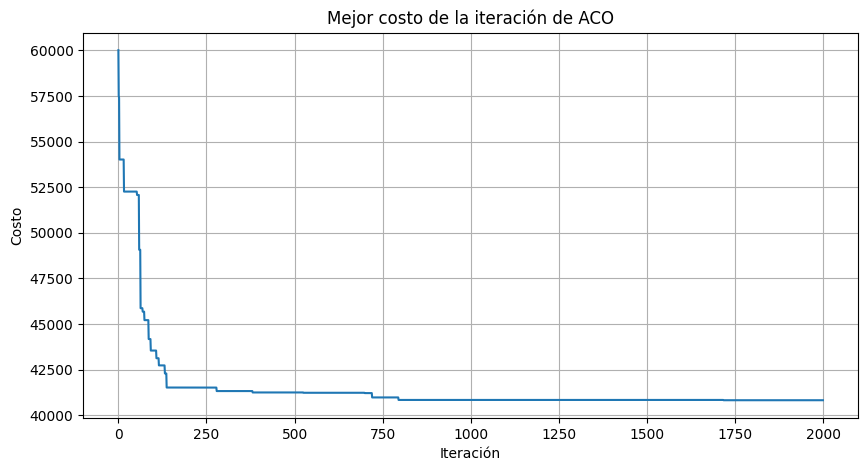

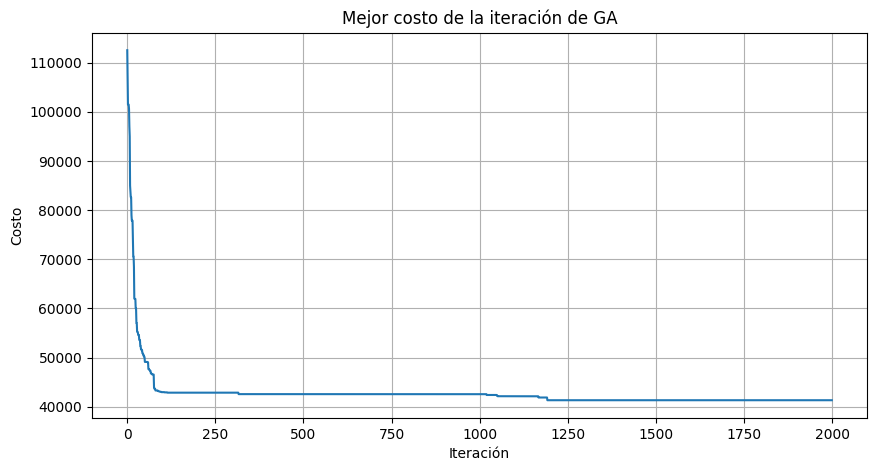

In [15]:
# Función para visualizar la evolución del costo
def plot_progress(costs, title):
    plt.figure(figsize=(10, 5))
    plt.plot(costs)
    plt.title(title)
    plt.xlabel('Iteración')
    plt.ylabel('Costo')
    plt.grid(True)
    plt.show()

# Cargar tu matriz de costos
costs = costos

# Resolver con ACO
print("Resolviendo con Colonia de Hormigas...")
aco = AntColony(costos)
aco_path, aco_cost = aco.solve()
print(f"Mejor ruta ACO: {aco_path}")
print(f"Costo ACO: {aco_cost:.2f}")

# Resolver con GA
print("\nResolviendo con Algoritmo Genético...")
ga = GeneticAlgorithm(costos)
ga_path, ga_cost = ga.solve()
print(f"Mejor ruta GA: {ga_path}")
print(f"Costo GA: {ga_cost:.2f}")

plot_progress(aco.global_best_costs, "Mejor costo de la iteración de ACO")
plot_progress(ga.global_best_costs, "Mejor costo de la iteración de GA")

En ambos casos, el costo total muestra una tendencia clara hacia la estabilización. Sin embargo, el algoritmo de colonia de hormigas demuestra ser ligeramente superior, ya que alcanza la estabilización más rápidamente en comparación con el algoritmo genético.

### Visualización de las rutas

Ya que tenemos los resultados de ambos algoritmos, vamos a visualizar ambas rutas óptimas, primero en un array y luego en un mapa.

In [16]:
for i in range(len(aco_path)):
    n = aco_path[i]
    print(capitales[n])

Mexicali
Chilpancingo
Hermosillo
Chihuahua
Saltillo
Monterrey
Ciudad Victoria
San Luis Potosí
Guanajuato
Santiago de Querétaro
Toluca
Ciudad de México
Cuernavaca
Puebla de Zaragoza
Tlaxcala de Xicohténcatl
Xalapa
Pachuca
Oaxaca de Juárez
Tuxtla Gutiérrez
Villahermosa
San Francisco de Campeche
Chetumal
Mérida
Morelia
Guadalajara
Tepic
Colima
Aguascalientes
Zacatecas
Victoria de Durango
Culiacán
La Paz


In [17]:
for i in range(len(ga_path)):
    n = ga_path[i]
    print(capitales[n],'')

Culiacán 
La Paz 
Mexicali 
Chilpancingo 
Hermosillo 
Chihuahua 
Victoria de Durango 
Zacatecas 
Aguascalientes 
Guanajuato 
Tlaxcala de Xicohténcatl 
Puebla de Zaragoza 
Oaxaca de Juárez 
Tuxtla Gutiérrez 
San Francisco de Campeche 
Chetumal 
Mérida 
Villahermosa 
Pachuca 
Xalapa 
Ciudad Victoria 
Monterrey 
Saltillo 
San Luis Potosí 
Santiago de Querétaro 
Toluca 
Ciudad de México 
Cuernavaca 
Morelia 
Guadalajara 
Colima 
Tepic 


Se definen las capitales y sus coordenadas para graficar los puntos en el mapa.

In [19]:
cities = {
    "Aguascalientes" : (21.884954379461, -102.30087174855659),
     "Mexicali" :(32.62397844887622, -115.45210378986265),
     "La Paz" : (24.142040140350385, -110.31286566477485),
     "San Francisco de Campeche" : (19.828160873262267, -90.52898305850493),
     "Tuxtla Gutiérrez": (16.751335365756486, -93.10224719394489),
     "Chihuahua" : (28.641285428744258, -106.06420957974598),
     "Ciudad de México": (19.434048951579648, -99.14500111218301),
     "Saltillo":(25.438117114747904, -100.97022453656616),
     "Colima":(19.24504022370353, -103.7255455150561),
     "Victoria de Durango":(24.022532436118173, -104.66228745578024),
     "Toluca":(19.281426634812927, -99.65660885147764),
     "Guanajuato":(21.01884384587014, -101.25592786690466),
     "Chilpancingo":(17.55174299817772, -99.50306648331134),
     "Pachuca":(20.101875517409372, -98.75770844786594),
    "Guadalajara":(20.675070408593626, -103.35050508741745),
    "Morelia":(19.7069969725094, -101.1937199480621),
    "Cuernavaca":(18.924043436792292, -99.22100149932828),
    "Tepic":(21.504963091503953, -104.89404571684773),
    "Monterrey":(25.68952142857185, -100.31313441570691),
    "Oaxaca de Juárez":(17.072737032689908, -96.72653898822182),
    "Puebla de Zaragoza":(19.040678012773434, -98.20591859051378),
    "Santiago de Querétaro":(20.588906278166366, -100.39007364850757),
    "Chetumal":(18.499752553195307, -88.29725154129385),
    "San Luis Potosí":(22.155398841366548, -100.97395536070933),
    "Culiacán":(24.809388365050896, -107.39464637152803),
    "Hermosillo":(29.071921195060096, -110.9454020089305),
    "Villahermosa":(17.988448188191917, -92.9468801296227),
    "Ciudad Victoria":(23.736761857100614, -99.1382952105799),
    "Tlaxcala de Xicohténcatl":(19.31398997615385, -98.24043502924535),
    "Xalapa":(19.539382167009634, -96.91786576788559),
    "Mérida":(20.96469876164016, -89.58972897863501),
    "Zacatecas":(22.772617659605732, -102.57567417784904)
}

Se define la función que crea los mapas.

In [20]:

def create_route_animation(cities, city_names, route):
    """
    Crea una visualización animada de la ruta entre ciudades usando Folium

    Args:
        cities (dict): Diccionario con formato {ciudad: (lat, lon)}
        city_names (list): Lista con los nombres de las ciudades
        route (list): Lista con índices que representan el orden de la ruta
    """
    # Calcular el centro del mapa
    lats = [coord[0] for coord in cities.values()]
    lons = [coord[1] for coord in cities.values()]
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)

    # Crear el mapa base
    m = folium.Map(location=[center_lat, center_lon],
                   zoom_start=6,
                   tiles='OpenStreetMap')

    # Añadir marcadores para todas las ciudades
    for city_name, coords in cities.items():
        folium.CircleMarker(
            location=coords,
            radius=6,
            popup=city_name,
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(m)

    # Crear la lista de coordenadas para la ruta
    print()
    route_coords = []
    for idx in route:
        city_name = city_names[idx]
        route_coords.append(cities[city_name])

    # Añadir la primera coordenada al final para cerrar el ciclo
    route_coords.append(route_coords[0])

    # Crear características para la animación
    features = []

    # Crear un marcador de antFeature para cada segmento de la ruta
    for i in range(len(route_coords) - 1):
        # Línea del segmento actual
        line = folium.PolyLine(
            locations=[route_coords[i], route_coords[i + 1]],
            weight=2,
            color='red',
            opacity=0.8
        )

        # Marcador animado
        moving_marker = plugins.AntPath(
            locations=[route_coords[i], route_coords[i + 1]],
            color='blue',
            weight=2,
            opacity=0.8,
            delay=1000,  # Velocidad de la animación
            dash_array=[10, 20]  # Patrón de la línea punteada
        )

        features.extend([line, moving_marker])
    start_city = city_names[route[0]]
    start_coords = cities[start_city]
    folium.Marker(
        location=start_coords,
        icon=folium.Icon(color='green', icon='flag', prefix='fa'),
        popup='Inicio'
    ).add_to(m)
    # Añadir todas las características al mapa
    for feature in features:
        feature.add_to(m)

    # Añadir una leyenda con información de la ruta
    route_info = f'Ruta: {" -> ".join([city_names[i] for i in route])+" -> "+(city_names[route[0]])}'
    legend_html = f'''
        <div style="position: fixed;
                    bottom: 50px; left: 50px; width: 300px; height: 250px;
                    border:2px solid grey; z-index:9999;
                    background-color:white;
                    opacity: 0.8;
                    font-size:12px;
                    padding: 10px">
            <p><b>Información de la Ruta:</b></p>
            <p>{route_info}</p>
        </div>
        '''
    m.get_root().html.add_child(folium.Element(legend_html))

    # Guardar el mapa
    m.save('route_animation.html')

    return m


 ### Mapa de la ruta óptima hallada por ACO.

In [21]:
map_viz = create_route_animation(cities, capitales, aco_path)
display(map_viz)

### Mapa de la ruta óptima hallada por GA.

In [22]:
map_viz = create_route_animation(cities, capitales,ga_path)
display(map_viz)

## Conclusión
En general, aunque los costos finales de ambas rutas son similares, las rutas generadas son diferentes. Al comparar ambos algoritmos, podemos concluir que ACO es más óptimo para resolver este tipo de problema debido a su capacidad para estabilizarse más rápidamente y explorar rutas prometedoras de manera más eficiente, especialmente en problemas donde el espacio de soluciones es grande y las relaciones entre nodos (ciudades) tienen costos variados.

Esta eficiencia puede deberse a que ACO utiliza feromonas y distancias para guiar la búsqueda hacia rutas de mejor calidad, mientras que GA depende más de procesos aleatorios como cruzamiento y mutación, lo que puede requerir más iteraciones para alcanzar resultados similares.